In [1]:
import os
import shutil
import random

# Paths
dataset_dir = 'dataset'  # Original dataset folder containing class subfolders
train_dir = 'train'  # Destination for training data
test_dir = 'test'  # Destination for testing data
split_ratio = 0.2  # 20% for testing, 80% for training

# Create train and test directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Iterate through each class folder in the dataset
for class_name in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_name)
    
    # Check if it's a directory (i.e., a class folder)
    if os.path.isdir(class_path):
        # Get all image filenames in the class folder
        images = os.listdir(class_path)
        random.shuffle(images)  # Shuffle images to split randomly

        # Split images into training and testing
        split_index = int(len(images) * (1 - split_ratio))
        train_images = images[:split_index]
        test_images = images[split_index:]

        # Create subdirectories for this class in train and test
        train_class_dir = os.path.join(train_dir, class_name)
        test_class_dir = os.path.join(test_dir, class_name)
        os.makedirs(train_class_dir, exist_ok=True)
        os.makedirs(test_class_dir, exist_ok=True)

        # Copy images to respective directories
        for img in train_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(train_class_dir, img))
        for img in test_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(test_class_dir, img))

print("Dataset split completed successfully!")


Dataset split completed successfully!


In [10]:
import tensorflow as tf

# Define dataset paths
train_dir = "train"
test_dir = "test"
batch_size = 32
img_size = (224, 224)

# Load dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    batch_size=batch_size,
    image_size=img_size
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    shuffle=True,
    batch_size=batch_size,
    image_size=img_size
)

# Get class-to-index mapping
class_names = train_dataset.class_names  # List of class names
num_classes = len(class_names)

# Print class encoding
print("Class Encoding:", {i: name for i, name in enumerate(class_names)})


Found 1549 files belonging to 15 classes.
Found 397 files belonging to 16 classes.
Class Encoding: {0: 'Bear', 1: 'Bird', 2: 'Cat', 3: 'Cow', 4: 'Deer', 5: 'Dog', 6: 'Dolphin', 7: 'Elephant', 8: 'Giraffe', 9: 'Horse', 10: 'Kangaroo', 11: 'Lion', 12: 'Panda', 13: 'Tiger', 14: 'Zebra'}


In [3]:
from tensorflow.keras.applications.resnet50 import preprocess_input

# Apply preprocessing
train_dataset = train_dataset.map(lambda x, y: (preprocess_input(x), y))
test_dataset = test_dataset.map(lambda x, y: (preprocess_input(x), y))

# Optimize dataset performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


In [5]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

# Load ResNet50 (Pretrained, No Top Layers)
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze All Layers Except Last Few
for layer in base_model.layers[:-10]:  # Train only last 10 layers
    layer.trainable = False

# Build Model on Top of ResNet50
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Reduce features to a vector
    layers.Dense(256, activation='relu'),  # Fully connected layer
    layers.Dropout(0.3),  # Prevent overfitting
    layers.Dense(len(class_names), activation='softmax')  # Output layer (Number of classes)
])

# Compile Model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Lower LR for stability
    loss="sparse_categorical_crossentropy",  # Integer labels
    metrics=["accuracy"]
)

model.summary()


94765736/94765736 [==============================] - 12s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 15)                3855      
                                                                 
Total params: 24116111 (92.00 MB)
Trainable params: 4994

In [7]:
epochs = 10  # Adjust as needed

history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=epochs
)


Epoch 1/10
49/49 [==============================] - 270s 5s/step - loss: 1.4373 - accuracy: 0.6114 - val_loss: 0.2470 - val_accuracy: 0.9063
Epoch 2/10
49/49 [==============================] - 259s 5s/step - loss: 0.2185 - accuracy: 0.9600 - val_loss: 0.1241 - val_accuracy: 0.9544
Epoch 3/10
49/49 [==============================] - 273s 6s/step - loss: 0.0787 - accuracy: 0.9877 - val_loss: 0.1034 - val_accuracy: 0.9595
Epoch 4/10
49/49 [==============================] - 292s 6s/step - loss: 0.0354 - accuracy: 0.9968 - val_loss: 0.0972 - val_accuracy: 0.9595
Epoch 5/10
49/49 [==============================] - 285s 6s/step - loss: 0.0178 - accuracy: 0.9987 - val_loss: 0.0940 - val_accuracy: 0.9595
Epoch 6/10
49/49 [==============================] - 285s 6s/step - loss: 0.0101 - accuracy: 1.0000 - val_loss: 0.0929 - val_accuracy: 0.9595
Epoch 7/10
49/49 [==============================] - 311s 6s/step - loss: 0.0084 - accuracy: 1.0000 - val_loss: 0.0854 - val_accuracy: 0.9595
Epoch 8/10
49

In [18]:
# Save the trained model
model.save("animal_classifier_resnet50.h5")


C:\Users\shaad\anaconda3\envs\datasc\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [20]:
# Save the trained model using the recommended .keras format
model.save("animal_classifier_resnet50.keras")

In [ ]:
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model("animal_classifier_resnet50.h5")

print("Model loaded successfully!")


In [5]:
from tensorflow import keras

# Load the saved model
model = keras.models.load_model("animal_classifier_resnet50.keras")

# Now you can use the model for inference or further training

In [12]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input

def predict_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  # Load image
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = preprocess_input(img_array)  # ResNet50 preprocessing

    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction)  # Get highest probability class
    predicted_class_name = class_names[predicted_class_index]  # Convert index to class

    print(f"Predicted: {predicted_class_name} with {np.max(prediction) * 100:.2f}% confidence")

# Test with an image
predict_image("test/Kangaroo/Kangaroo_16_3.jpg")

1/1 [==============================] - 0s 202ms/step
Predicted: Kangaroo with 66.56% confidence


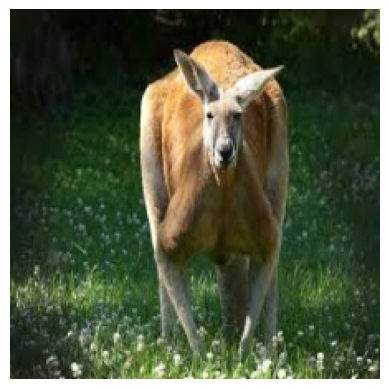

1/1 [==============================] - 0s 235ms/step
Predicted animal by the model: Kangaroo
Predicted animal by the model: Kangaroo with 98.75% confidence


In [28]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input

def predict_image(img_path):
    # Display the image
    img = mpimg.imread(img_path)  # Read the image
    plt.imshow(img)
    plt.axis("off")  # Hide axis
    plt.show()
    
    # Load and preprocess image for model prediction
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = preprocess_input(img_array)  # Preprocess for ResNet50

    # Predict using the model
    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction)  # Get highest probability class
    predicted_class_name = class_names[predicted_class_index]  # Convert index to class

    print(f"Predicted animal by the model: {predicted_class_name}")
    #print(f"Predicted animal by the model: {predicted_class_name} with {np.max(prediction) * 100:.2f}% confidence")

# Test with an image
predict_image("test/Kangaroo/Kangaroo_28.jpeg")


1/1 [==============================] - 0s 200ms/step


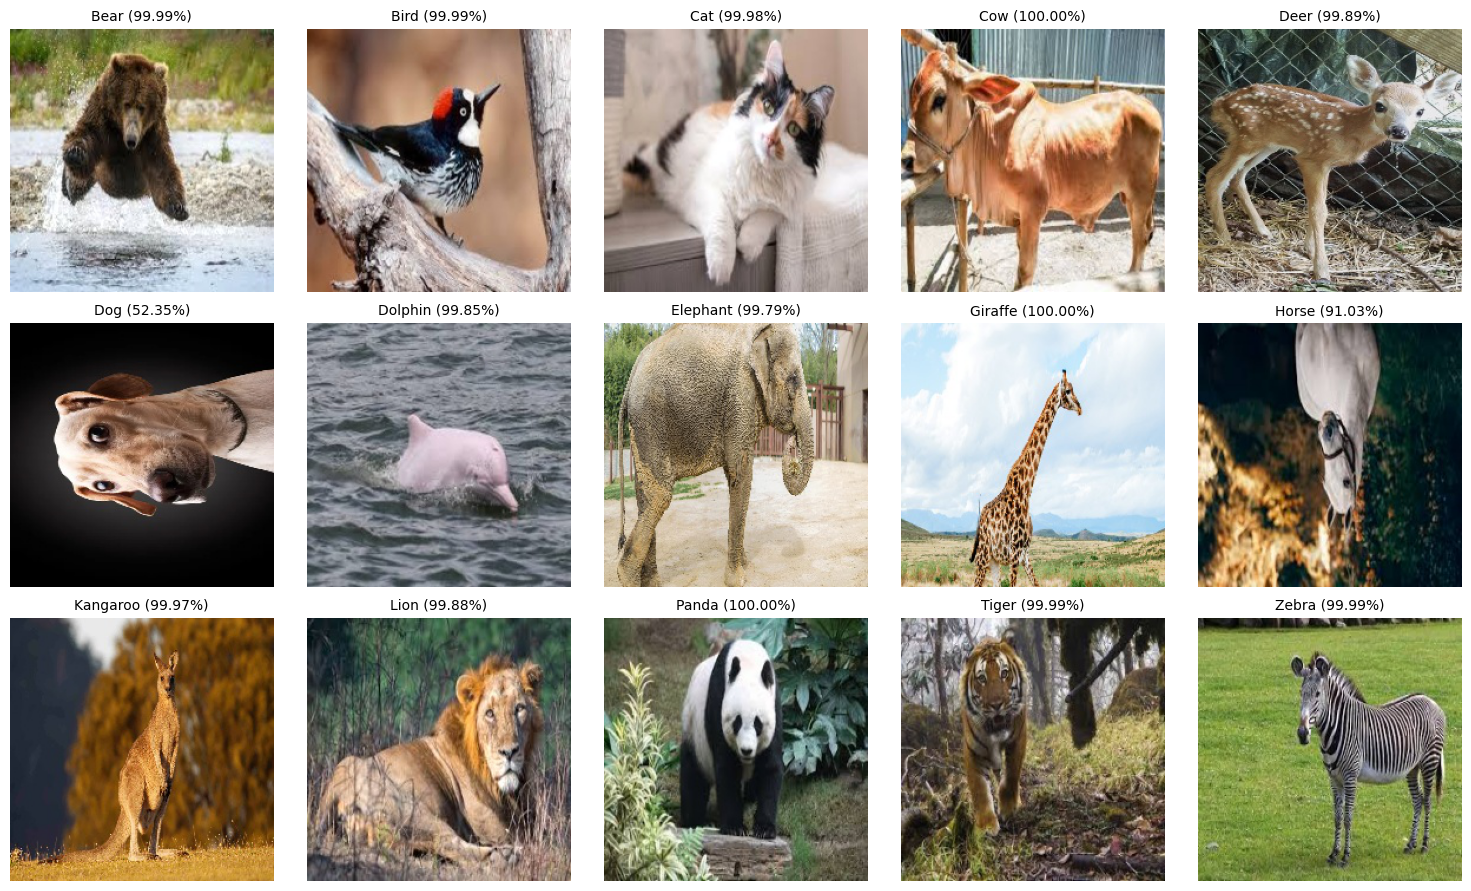

Predicted images saved as predictions.png


In [52]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import load_model

# Load the trained model
#model = load_model("animal_classifier_resnet50.h5")

# List of class names (should match training labels)
class_names = ['Bear', 'Bird', 'Cat', 'Cow', 'Deer', 'Dog', 'Dolphin', 'Elephant', 
               'Giraffe', 'Horse', 'Kangaroo', 'Lion', 'Panda', 'Tiger', 'Zebra']

# Path to test dataset
test_dir = "test/"

# Function to predict class of an image
def predict_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = preprocess_input(img_array)  # Preprocess for ResNet50

    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction)
    predicted_class_name = class_names[predicted_class_index]
    confidence = np.max(prediction) * 100  # Confidence score

    return predicted_class_name, confidence

# Select one random image per class
fig, axes = plt.subplots(3, 5, figsize=(15, 9))  # Adjust grid size
axes = axes.flatten()

for i, class_name in enumerate(class_names):
    class_path = os.path.join(test_dir, class_name)
    if not os.path.exists(class_path):
        print(f"Skipping {class_name} as folder not found.")
        continue

    # Get list of images in class folder
    image_files = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.png', '.jpeg'))]
    
    if not image_files:
        print(f"No images found for class {class_name}")
        continue

    # Pick a random image
    img_name = random.choice(image_files)
    img_path = os.path.join(class_path, img_name)

    # Run prediction
    predicted_class, confidence = predict_image(img_path)

    # Display the image with prediction
    img = mpimg.imread(img_path)
    axes[i].imshow(img)
    axes[i].axis("off")
    axes[i].set_title(f"{predicted_class} ({confidence:.2f}%)", fontsize=10)

plt.tight_layout()
save_path = "predictions.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()
print(f"Predicted images saved as {save_path}")


In [54]:
import os
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import load_model


# List of class names (should match training labels)
class_names = ['Bear', 'Bird', 'Cat', 'Cow', 'Deer', 'Dog', 'Dolphin', 'Elephant', 
               'Giraffe', 'Horse', 'Kangaroo', 'Lion', 'Panda', 'Tiger', 'Zebra']

# Path to test dataset
test_dir = "test/"

# Dictionary to store statistics
stats = {class_name: {'total': 0, 'correct': 0, 'incorrect': 0} for class_name in class_names}

# Function to predict class of an image
def predict_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = preprocess_input(img_array)  # Preprocess for ResNet50

    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction)
    predicted_class_name = class_names[predicted_class_index]
    
    return predicted_class_name

# Iterate over each class folder
for class_name in class_names:
    class_path = os.path.join(test_dir, class_name)
    if not os.path.exists(class_path):
        print(f"Skipping {class_name} as folder not found.")
        continue

    # Get list of images in class folder
    image_files = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.png', '.jpeg'))]
    
    # Update total count
    stats[class_name]['total'] = len(image_files)

    # Predict each image
    for img_name in image_files:
        img_path = os.path.join(class_path, img_name)
        predicted_class = predict_image(img_path)

        if predicted_class == class_name:
            stats[class_name]['correct'] += 1
        else:
            stats[class_name]['incorrect'] += 1

# Calculate overall accuracy
total_images = sum(stats[c]['total'] for c in class_names)
total_correct = sum(stats[c]['correct'] for c in class_names)
overall_accuracy = (total_correct / total_images) * 100 if total_images > 0 else 0

# Print statistics
print("\nClassification Statistics:")
print("=" * 40)
for class_name, values in stats.items():
    print(f"Class: {class_name}")
    print(f"  Total Images    : {values['total']}")
    print(f"  Correctly Predicted : {values['correct']}")
    print(f"  Incorrectly Predicted : {values['incorrect']}")
    print("-" * 40)

print(f"\nOverall Model Accuracy: {overall_accuracy:.2f}% ({total_correct}/{total_images} correct predictions)")


1/1 [==============================] - 0s 183ms/step

Classification Statistics:
Class: Bear
  Total Images    : 25
  Correctly Predicted : 24
  Incorrectly Predicted : 1
----------------------------------------
Class: Bird
  Total Images    : 28
  Correctly Predicted : 26
  Incorrectly Predicted : 2
----------------------------------------
Class: Cat
  Total Images    : 25
  Correctly Predicted : 25
  Incorrectly Predicted : 0
----------------------------------------
Class: Cow
  Total Images    : 27
  Correctly Predicted : 26
  Incorrectly Predicted : 1
----------------------------------------
Class: Deer
  Total Images    : 26
  Correctly Predicted : 24
  Incorrectly Predicted : 2
----------------------------------------
Class: Dog
  Total Images    : 25
  Correctly Predicted : 24
  Incorrectly Predicted : 1
----------------------------------------
Class: Dolphin
  Total Images    : 26
  Correctly Predicted : 25
  Incorrectly Predicted : 1
----------------------------------------
Cl